### Import Packages

SKLearn library forces depreciation warnings which have no effect on the reliability of the project, so these will be silenced here

In [56]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [57]:
import numpy as np
import pandas as pd

# machine learning specific functions
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

%store -r df

### Perform Model

#### Create Validation Dataset

In [58]:
# get classifier values (online, offline)
y = df['status'].values

# get station name values
X1 = df['station_name']

# get all values that are after the status (timing information and prediction values)
status_index = df.columns.get_loc('status')
X2 = df.iloc[:, status_index + 1:]

# combine X1 and X2
X = pd.concat([X1, X2], axis=1).values

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.20, random_state=7)

X_train = X_train.astype('float')
X_validation = X_validation.astype('float')
y_train = y_train
y_validation = y_validation

#### Assign Models that should be tested

In [59]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

#### Evaluate Each Model

In [60]:
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.946976 (0.003171)
LDA: 0.930068 (0.003262)
KNN: 0.946778 (0.002232)
CART: 0.924914 (0.004078)
NB: 0.868938 (0.013439)


#### Compare Algorithms

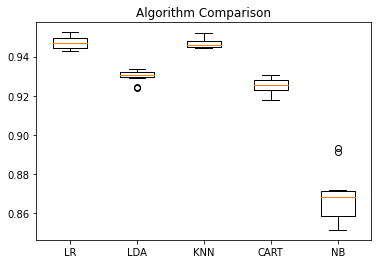

In [61]:
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

#### Choose Model with highest Precision

In [62]:
max_prec = 0

for index in range(0, len(models)):
    prec = results[index].mean()

    if prec > max_prec:
        max_prec = prec
        model = models[index]

print('Algorithm ' + model[0] + ' scored highest precision')

# model consists of tuple with name
model = model[1]

Algorithm LR scored highest precision


#### Fit selected Model

In [63]:
model.fit(X_train, y_train)
predictions = model.predict(X_validation)

#### Evaluate Predictions 

In [64]:
print(accuracy_score(y_validation, predictions))
print(confusion_matrix(y_validation, predictions))
print(classification_report(y_validation, predictions))

0.949734401014826
[[  218   519]
 [  115 11761]]
              precision    recall  f1-score   support

     offline       0.65      0.30      0.41       737
      online       0.96      0.99      0.97     11876

    accuracy                           0.95     12613
   macro avg       0.81      0.64      0.69     12613
weighted avg       0.94      0.95      0.94     12613

